In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import ActorPolicy
from tf_agents.networks import value_network
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg.actor_network import ActorNetwork
from tf_agents.agents.ddpg.critic_network import CriticNetwork
from tf_agents.utils import common
import tempfile, os

import matplotlib.pyplot as plt
import qutip
from qutip import expect, sigmap

import random

import sys
sys.path.append('../')
from environments.qubit_env import QubitContinuousEnv
from common.common import get_average_return, extract_double_action_policy

%matplotlib inline

* System Parameters

In [2]:
T = 5 # terminal time step
max_steps = 20 # number of time steps

fc_layer_params = (100, 75)
replay_buffer_capacity = 50000
nb_episodes = 20
eval_interval = 10
log_interval = 20
batch_size = 100
actor_learning_rate = 1e-2
critic_learning_rate = 1e-2
seed = 1989
tf.random.set_seed(seed)

checkpoint_dir = "/home/dkoytrom/Msc_Quantum_Computing_Quantum_Technologies/Master_Thesis/algorithms/classical/Reinforcement_learning/checkpoints/Ddpg_continuous_qubit/"

nb_iterations = 3000

In [3]:
max_Ω = 1.0
max_Δ = 0.5

environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)
eval_environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

* Actor/Policy network

In [4]:
actor_network = ActorNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy"
)

critic_network = CriticNetwork(
    input_tensor_spec = (train_env.time_step_spec().observation, train_env.action_spec()),
    observation_fc_layer_params= (100, 75),
)

# use tha Adam optimizers
actor_optimizer = tf.keras.optimizers.Adam(learning_rate = actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate = critic_learning_rate)

train_step_counter = tf.Variable(0)

agent = ddpg_agent.DdpgAgent(
    time_step_spec = environment.time_step_spec(),
    action_spec = environment.action_spec(),
    actor_network = actor_network,
    critic_network = critic_network,
    actor_optimizer = actor_optimizer,
    critic_optimizer = critic_optimizer,
    train_step_counter = train_step_counter,
    gamma = 0.99,
    ou_stddev = 1,
    ou_damping = 1,
    target_update_tau = 0.5,
)

agent.initialize()

2024-01-16 20:55:46.529027: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dkoytrom-pc
2024-01-16 20:55:46.529043: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dkoytrom-pc
2024-01-16 20:55:46.529122: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-01-16 20:55:46.529145: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.29.6


In [5]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

# collect data
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers = [replay_buffer.add_batch],
    num_steps = max_steps
)

# create checkpointer to load training and continue
checkpointer = common.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore()

In [6]:
avg_returns = []
losses = []

# loop for all iterations
for _ in range(nb_iterations):
    collect_driver.run()

    # get the dataset
    dataset = replay_buffer.as_dataset(
        num_parallel_calls = 3,
        sample_batch_size = batch_size,
        num_steps = 2
    ).prefetch(3)

    iterator = iter(dataset)

    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        losses.append(train_loss)

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)

checkpointer.save(train_step_counter)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


step = 20: loss = 0.36521193385124207
step = 40: loss = 1.7685561180114746
step = 60: loss = 1.1663823127746582
step = 80: loss = 1.7212523221969604
step = 100: loss = 1.4350051879882812
step = 120: loss = 3.704735040664673
step = 140: loss = 3.0429553985595703
step = 160: loss = 3.4870474338531494
step = 180: loss = 2.424534559249878
step = 200: loss = 4.192694664001465
step = 220: loss = 5.172323703765869
step = 240: loss = 4.258002758026123
step = 260: loss = 5.126131057739258
step = 280: loss = 7.151998996734619
step = 300: loss = 11.080245018005371
step = 320: loss = 10.306798934936523
step = 340: loss = 7.682864189147949
step = 360: loss = 6.875280857086182
step = 380: loss = 4.190657138824463
step = 400: loss = 7.668644905090332
step = 420: loss = 6.8165059089660645
step = 440: loss = 6.132601737976074
step = 460: loss = 7.745311737060547
step = 480: loss = 6.421693325042725
step = 500: loss = 7.549983024597168
step = 520: loss = 10.101118087768555
step = 540: loss = 9.497304916

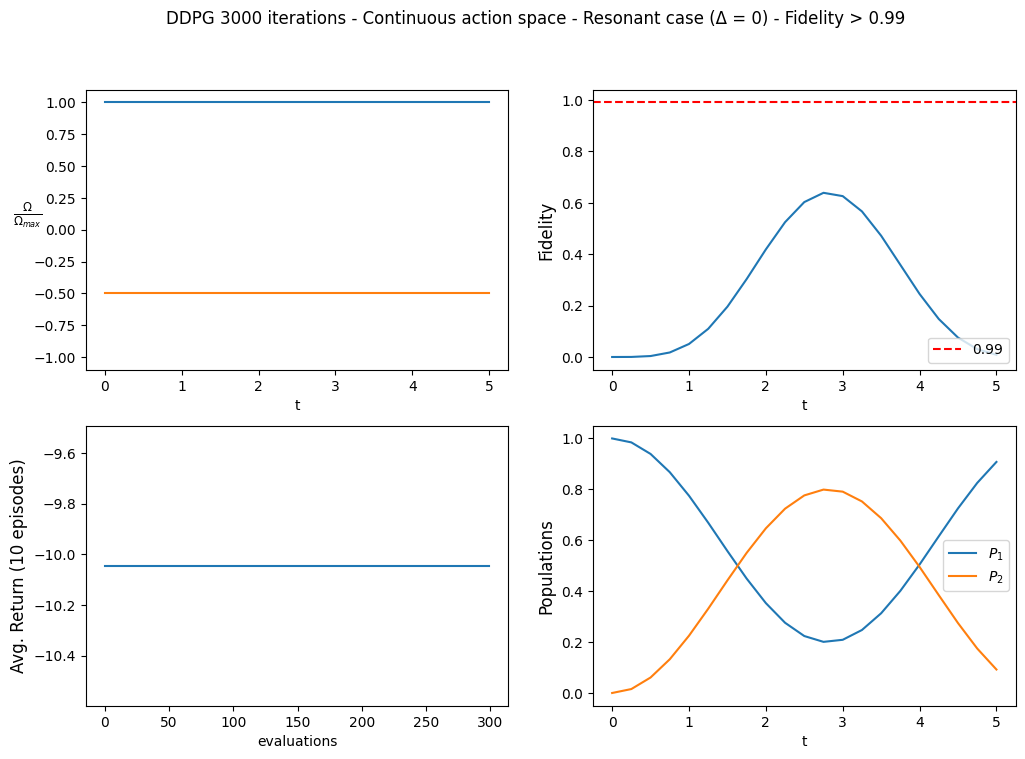

In [9]:
greedy_actions, [optimal_omegas, optimal_detuning], states, fidelities = extract_double_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'DDPG {nb_iterations} iterations - Continuous action space - Resonant case (Δ = 0) - Fidelity > 0.99')

ax1.step(time_span, optimal_omegas, where = 'post')
ax1.step(time_span, optimal_detuning, where = 'post')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
plt.show()